# Import required libraries

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [34]:
torch.__version__

'2.1.0+cu121'

In [35]:
torchvision.__version__

'0.16.0+cu121'

## 2. Setup Device-Agnostic Code

In [36]:
!nvidia-smi

Tue Jun 10 15:07:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:65:00.0 Off |                  N/A |
|  0%   51C    P8              17W / 350W |     19MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [37]:
torch.cuda.is_available()

True

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [39]:
print(f"Using Device: {device}")

Using Device: cuda


## 3. Set the seed

In [40]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

## 4. Setting the hyperprameters

In [41]:
3e-4

0.0003

In [42]:
BATCH_SIZE = 128
EPOCHS = 100 # Try increasing epochs 
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 100
IMAGE_SIZE = 32 # Transform the image and make the size go to 224
CHANNELS = 3
EMBED_DIM = 192
NUM_HEADS = 4# INcrease the number heads
DEPTH = 6
MLP_DIM = 384
DROP_RATE = 0.2

## 5. Define Image Transformations

In [43]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5071, 0.4867, 0.4408), 
        (0.2675, 0.2565, 0.2761)
    )
])

In [44]:

# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])

## 6. Getting a dataset

In [45]:
from torchvision import datasets

train_dataset = datasets.CIFAR100(root='data', train=True, transform=transform_train, download=True)


Files already downloaded and verified


In [46]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)


In [47]:
for x, y in train_loader:
    print(x.shape)  # Should be: torch.Size([BATCH_SIZE, 3, 224, 224])
    break


torch.Size([128, 3, 32, 32])


In [48]:

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5071, 0.4867, 0.4408), 
        (0.2675, 0.2565, 0.2761)
    )
])


In [49]:
# transform_test = transforms.Compose([
#     transforms.Resize(32),  # Match model's expected input size
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])


In [50]:
test_dataset = datasets.CIFAR100(root="data",
                                 train=False,
                                 download=True,
                                 transform=transform_test)


Files already downloaded and verified


In [51]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)


In [52]:
train_dataset

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.1, 0.1))
               ToTensor()
               Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
           )

In [53]:
test_dataset

Dataset CIFAR100
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
           )

In [54]:
len(train_dataset)

50000

In [55]:
len(test_dataset)

10000

## 7. Converting our datasets into dataloaders

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our data into batches or (mini-batches)

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memroy) at 50000 images in one hit. So we break it into 128 images at a time. (batch size of 128).
2. It gives our neural network more chances to update its gradients per epoch

In [56]:
BATCH_SIZE

128

In [57]:
# Let's check out what we've created
print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7f9a8725a6b0>, <torch.utils.data.dataloader.DataLoader object at 0x7f99d8604a90>)
Length of train_loader: 391 batches of 128...
Length of test_loader: 79 batches of 128...


In [58]:
for x, y in train_loader:
    print(x.shape)  # Expect: (batch_size, 3, 224, 224)
    break


torch.Size([128, 3, 32, 32])


In [59]:
128 * 390.625

50000.0

In [60]:
50000 / 128

390.625

## 8. Building Vision Transformer Model From Scratch

In [61]:
PATCH_SIZE

4

In [62]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 img_size=32,
                 patch_size=4,
                 in_channels=3,
                 embed_dim=192):  
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels=in_channels,
                              out_channels=embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)
        
        num_patches = (img_size // patch_size) ** 2  # (32 / 4)^2 = 64
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))  # 1 + 64 = 65
        
        

    def forward(self, x: torch.Tensor):
        B = x.size(0)
        x = self.proj(x)                           # Shape: (B, E, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)           # Shape: (B, N, E)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)      # Shape: (B, 1+N, E)
        x = x + self.pos_embed                     # Positional embedding aEpoch: 84/100, Train loss: 2.3105, Train acc: 52.1520, Test acc: 52.6900

        return x


In [63]:
F

<module 'torch.nn.functional' from '/home/iiit/anaconda3/envs/a1/lib/python3.10/site-packages/torch/nn/functional.py'>

In [64]:
class MLP(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [65]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

In [66]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token = x[:, 0]
        return self.head(cls_token)

In [67]:
DEPTH

6

In [68]:
device

'cuda'

In [69]:
# Instantiate model
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

In [70]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=192, out_features=384, bias=True)
        (fc2): Linear(in_features=384, out_features=192, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

## 9. Defining a Loss function and an optimizer

In [71]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # Measure how wrong our model is
optimizer = torch.optim.Adam(params=model.parameters(), # update our model's parameters to try and reduce the loss
                             lr=LEARNING_RATE,weight_decay=5e-4)

In [72]:
criterion

CrossEntropyLoss()

In [73]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0.0005
)

## 10. Defining a Training Loop function

In [74]:
device

'cuda'

In [75]:
def train(model, loader, optimizer, criterion):
    # Set the mode of the model into training
    model.train()

    total_loss, correct = 0, 0

    for x, y in loader:
        # Moving (Sending) our data into the target device
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # 1. Forward pass (model outputs raw logits)
        out = model(x)
        # 2. Calcualte loss (per batch)
        loss = criterion(out, y)
        # 3. Perform backpropgation
        loss.backward()
        # 4. Perforam Gradient Descent
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
   
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [76]:
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)
    return 100 * correct / total


In [77]:
EPOCHS

100

In [78]:
print(model.patch_embed.pos_embed.shape)

torch.Size([1, 65, 192])


In [79]:
# Quick debug after your model definition and DataLoader setup
x, y = next(iter(train_loader))
print("Input batch shape:", x.shape)  # Expected: [batch_size, 3, 32, 32]
print("Positional embedding shape:", model.patch_embed.pos_embed.shape)

# Include a forward pass through only the patch embedding:
out = model.patch_embed(x.to(device))
print("Patch embed output shape:", out.shape)  # Should be [batch_size, 65, 192]


Input batch shape: torch.Size([128, 3, 32, 32])
Positional embedding shape: torch.Size([1, 65, 192])
Patch embed output shape: torch.Size([128, 65, 192])


In [80]:
# Rebuild the model and optimizer
model = VisionTransformer(
    img_size=32,
    patch_size=4,
    in_channels=3,
    num_classes=100,
    embed_dim=192,
    depth=6,
    num_heads=4,
    mlp_dim=384,
    drop_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=5e-4)


In [81]:
from tqdm.auto import tqdm

In [82]:
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)

    train_accuracies.append(train_acc * 100)  # Store as percentage
    test_accuracies.append(test_acc)          # Already in percentage

    print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc * 100:.4f}, Test acc: {test_acc:.4f}")



    # print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc * 100:.2f}%, Test acc: {test_acc:.4f}")

  1%|          | 1/100 [00:45<1:15:47, 45.93s/it]

Epoch: 1/100, Train loss: 4.3000, Train acc: 5.4740, Test acc: 10.9900


  2%|▏         | 2/100 [01:30<1:13:30, 45.01s/it]

Epoch: 2/100, Train loss: 3.9856, Train acc: 11.1600, Test acc: 16.6000


  3%|▎         | 3/100 [02:15<1:12:44, 44.99s/it]

Epoch: 3/100, Train loss: 3.7995, Train acc: 14.8620, Test acc: 19.6100


  4%|▍         | 4/100 [02:59<1:11:13, 44.52s/it]

Epoch: 4/100, Train loss: 3.6886, Train acc: 17.4320, Test acc: 21.2800


  5%|▌         | 5/100 [03:44<1:10:44, 44.68s/it]

Epoch: 5/100, Train loss: 3.6110, Train acc: 18.9900, Test acc: 23.4600


  6%|▌         | 6/100 [04:29<1:10:14, 44.84s/it]

Epoch: 6/100, Train loss: 3.5489, Train acc: 20.3980, Test acc: 24.9000


  7%|▋         | 7/100 [05:14<1:09:31, 44.85s/it]

Epoch: 7/100, Train loss: 3.4989, Train acc: 21.6620, Test acc: 26.5400


  8%|▊         | 8/100 [05:59<1:09:12, 45.14s/it]

Epoch: 8/100, Train loss: 3.4489, Train acc: 22.6480, Test acc: 26.9700


  9%|▉         | 9/100 [06:45<1:08:35, 45.22s/it]

Epoch: 9/100, Train loss: 3.4045, Train acc: 23.6940, Test acc: 28.5600


 10%|█         | 10/100 [07:30<1:07:52, 45.26s/it]

Epoch: 10/100, Train loss: 3.3648, Train acc: 24.8520, Test acc: 29.7500


 11%|█         | 11/100 [08:15<1:06:56, 45.12s/it]

Epoch: 11/100, Train loss: 3.3231, Train acc: 25.5340, Test acc: 30.2900


 12%|█▏        | 12/100 [09:00<1:06:07, 45.09s/it]

Epoch: 12/100, Train loss: 3.2870, Train acc: 26.4960, Test acc: 31.6400


 13%|█▎        | 13/100 [09:45<1:05:16, 45.01s/it]

Epoch: 13/100, Train loss: 3.2488, Train acc: 27.3700, Test acc: 32.3400


 14%|█▍        | 14/100 [10:29<1:04:02, 44.68s/it]

Epoch: 14/100, Train loss: 3.2159, Train acc: 28.2200, Test acc: 33.8800


 15%|█▌        | 15/100 [11:14<1:03:31, 44.84s/it]

Epoch: 15/100, Train loss: 3.1795, Train acc: 29.0400, Test acc: 33.6800


 16%|█▌        | 16/100 [12:00<1:03:07, 45.09s/it]

Epoch: 16/100, Train loss: 3.1524, Train acc: 29.8480, Test acc: 35.0800


 17%|█▋        | 17/100 [12:45<1:02:21, 45.07s/it]

Epoch: 17/100, Train loss: 3.1220, Train acc: 30.3400, Test acc: 36.5400


 18%|█▊        | 18/100 [13:30<1:01:37, 45.09s/it]

Epoch: 18/100, Train loss: 3.0974, Train acc: 31.1040, Test acc: 36.6200


 19%|█▉        | 19/100 [14:15<1:00:46, 45.02s/it]

Epoch: 19/100, Train loss: 3.0751, Train acc: 31.6360, Test acc: 36.6900


 20%|██        | 20/100 [14:59<59:46, 44.84s/it]  

Epoch: 20/100, Train loss: 3.0480, Train acc: 32.3540, Test acc: 37.6700


 21%|██        | 21/100 [15:44<58:58, 44.79s/it]

Epoch: 21/100, Train loss: 3.0250, Train acc: 32.6900, Test acc: 37.7300


 22%|██▏       | 22/100 [16:29<58:24, 44.94s/it]

Epoch: 22/100, Train loss: 3.0051, Train acc: 33.3720, Test acc: 38.6100


 23%|██▎       | 23/100 [17:14<57:33, 44.84s/it]

Epoch: 23/100, Train loss: 2.9843, Train acc: 33.8080, Test acc: 39.1600


 24%|██▍       | 24/100 [17:59<56:57, 44.97s/it]

Epoch: 24/100, Train loss: 2.9657, Train acc: 34.3660, Test acc: 39.1100


 25%|██▌       | 25/100 [18:44<56:09, 44.92s/it]

Epoch: 25/100, Train loss: 2.9409, Train acc: 34.8260, Test acc: 40.1400


 26%|██▌       | 26/100 [19:28<55:02, 44.63s/it]

Epoch: 26/100, Train loss: 2.9142, Train acc: 35.5420, Test acc: 40.9600


 27%|██▋       | 27/100 [20:13<54:26, 44.75s/it]

Epoch: 27/100, Train loss: 2.8902, Train acc: 36.3060, Test acc: 41.5500


 28%|██▊       | 28/100 [20:57<53:26, 44.54s/it]

Epoch: 28/100, Train loss: 2.8693, Train acc: 36.7440, Test acc: 41.5500


 29%|██▉       | 29/100 [21:41<52:44, 44.57s/it]

Epoch: 29/100, Train loss: 2.8532, Train acc: 37.3320, Test acc: 42.9500


 30%|███       | 30/100 [22:27<52:24, 44.93s/it]

Epoch: 30/100, Train loss: 2.8335, Train acc: 37.6100, Test acc: 41.8800


 31%|███       | 31/100 [23:12<51:49, 45.07s/it]

Epoch: 31/100, Train loss: 2.8122, Train acc: 38.2020, Test acc: 43.7600


 32%|███▏      | 32/100 [23:56<50:41, 44.73s/it]

Epoch: 32/100, Train loss: 2.7952, Train acc: 38.5680, Test acc: 42.8400


 33%|███▎      | 33/100 [24:41<49:56, 44.72s/it]

Epoch: 33/100, Train loss: 2.7809, Train acc: 39.0220, Test acc: 44.6600


 34%|███▍      | 34/100 [25:27<49:32, 45.04s/it]

Epoch: 34/100, Train loss: 2.7604, Train acc: 39.5760, Test acc: 44.6600


 35%|███▌      | 35/100 [26:12<48:58, 45.21s/it]

Epoch: 35/100, Train loss: 2.7447, Train acc: 39.8740, Test acc: 44.8600


 36%|███▌      | 36/100 [26:57<47:58, 44.98s/it]

Epoch: 36/100, Train loss: 2.7274, Train acc: 40.5340, Test acc: 46.1600


 37%|███▋      | 37/100 [27:42<47:08, 44.89s/it]

Epoch: 37/100, Train loss: 2.7069, Train acc: 40.7260, Test acc: 46.7200


 38%|███▊      | 38/100 [28:26<46:20, 44.85s/it]

Epoch: 38/100, Train loss: 2.6925, Train acc: 41.4660, Test acc: 46.9000


 39%|███▉      | 39/100 [29:11<45:32, 44.79s/it]

Epoch: 39/100, Train loss: 2.6805, Train acc: 41.3740, Test acc: 46.9800


 40%|████      | 40/100 [29:56<44:46, 44.78s/it]

Epoch: 40/100, Train loss: 2.6566, Train acc: 42.3620, Test acc: 46.6100


 41%|████      | 41/100 [30:40<43:53, 44.64s/it]

Epoch: 41/100, Train loss: 2.6469, Train acc: 42.2720, Test acc: 47.5200


 42%|████▏     | 42/100 [31:25<43:07, 44.62s/it]

Epoch: 42/100, Train loss: 2.6328, Train acc: 42.9800, Test acc: 47.2300


 43%|████▎     | 43/100 [32:10<42:36, 44.85s/it]

Epoch: 43/100, Train loss: 2.6237, Train acc: 43.4180, Test acc: 47.5600


 44%|████▍     | 44/100 [32:56<42:02, 45.05s/it]

Epoch: 44/100, Train loss: 2.6056, Train acc: 43.6420, Test acc: 48.4100


 45%|████▌     | 45/100 [33:40<41:05, 44.82s/it]

Epoch: 45/100, Train loss: 2.5952, Train acc: 44.3060, Test acc: 48.6800


 46%|████▌     | 46/100 [34:25<40:26, 44.93s/it]

Epoch: 46/100, Train loss: 2.5814, Train acc: 44.3420, Test acc: 48.9000


 47%|████▋     | 47/100 [35:09<39:32, 44.75s/it]

Epoch: 47/100, Train loss: 2.5747, Train acc: 44.5840, Test acc: 49.8100


 48%|████▊     | 48/100 [35:53<38:37, 44.57s/it]

Epoch: 48/100, Train loss: 2.5623, Train acc: 44.9400, Test acc: 49.3600


 49%|████▉     | 49/100 [36:39<38:10, 44.91s/it]

Epoch: 49/100, Train loss: 2.5575, Train acc: 45.2220, Test acc: 49.7300


 50%|█████     | 50/100 [37:23<37:15, 44.72s/it]

Epoch: 50/100, Train loss: 2.5395, Train acc: 45.5040, Test acc: 50.0200


 51%|█████     | 51/100 [38:08<36:34, 44.78s/it]

Epoch: 51/100, Train loss: 2.5385, Train acc: 45.7140, Test acc: 49.7400


 52%|█████▏    | 52/100 [38:53<35:45, 44.69s/it]

Epoch: 52/100, Train loss: 2.5246, Train acc: 45.5120, Test acc: 50.0300


 53%|█████▎    | 53/100 [39:38<35:08, 44.87s/it]

Epoch: 53/100, Train loss: 2.5177, Train acc: 46.1700, Test acc: 50.4500


 54%|█████▍    | 54/100 [40:24<34:33, 45.07s/it]

Epoch: 54/100, Train loss: 2.5091, Train acc: 46.3400, Test acc: 51.0800


 55%|█████▌    | 55/100 [41:08<33:40, 44.90s/it]

Epoch: 55/100, Train loss: 2.4968, Train acc: 46.5900, Test acc: 50.9200


 56%|█████▌    | 56/100 [41:53<33:00, 45.02s/it]

Epoch: 56/100, Train loss: 2.4897, Train acc: 47.0740, Test acc: 50.7200


 57%|█████▋    | 57/100 [42:38<32:02, 44.72s/it]

Epoch: 57/100, Train loss: 2.4840, Train acc: 47.2180, Test acc: 50.8300


 58%|█████▊    | 58/100 [43:23<31:22, 44.82s/it]

Epoch: 58/100, Train loss: 2.4765, Train acc: 47.4020, Test acc: 51.6100


 59%|█████▉    | 59/100 [44:06<30:20, 44.39s/it]

Epoch: 59/100, Train loss: 2.4659, Train acc: 47.7700, Test acc: 50.8200


 60%|██████    | 60/100 [44:50<29:31, 44.28s/it]

Epoch: 60/100, Train loss: 2.4573, Train acc: 48.0560, Test acc: 51.9700


 61%|██████    | 61/100 [45:34<28:40, 44.12s/it]

Epoch: 61/100, Train loss: 2.4502, Train acc: 48.0260, Test acc: 51.3800


 62%|██████▏   | 62/100 [46:18<27:53, 44.04s/it]

Epoch: 62/100, Train loss: 2.4434, Train acc: 48.1860, Test acc: 51.5500


 63%|██████▎   | 63/100 [47:02<27:09, 44.03s/it]

Epoch: 63/100, Train loss: 2.4336, Train acc: 48.3400, Test acc: 52.3000


 64%|██████▍   | 64/100 [47:46<26:25, 44.04s/it]

Epoch: 64/100, Train loss: 2.4220, Train acc: 48.9140, Test acc: 52.0600


 65%|██████▌   | 65/100 [48:30<25:43, 44.10s/it]

Epoch: 65/100, Train loss: 2.4249, Train acc: 48.9740, Test acc: 52.5800


 66%|██████▌   | 66/100 [49:15<25:09, 44.39s/it]

Epoch: 66/100, Train loss: 2.4167, Train acc: 48.9220, Test acc: 53.1500


 67%|██████▋   | 67/100 [50:01<24:36, 44.75s/it]

Epoch: 67/100, Train loss: 2.4049, Train acc: 49.2440, Test acc: 52.1200


 68%|██████▊   | 68/100 [50:46<23:58, 44.94s/it]

Epoch: 68/100, Train loss: 2.4046, Train acc: 49.3120, Test acc: 51.5000


 69%|██████▉   | 69/100 [51:31<23:11, 44.90s/it]

Epoch: 69/100, Train loss: 2.3981, Train acc: 49.5840, Test acc: 52.8900


 70%|███████   | 70/100 [52:16<22:28, 44.94s/it]

Epoch: 70/100, Train loss: 2.3912, Train acc: 49.7400, Test acc: 52.9600


 71%|███████   | 71/100 [53:00<21:41, 44.88s/it]

Epoch: 71/100, Train loss: 2.3892, Train acc: 49.9460, Test acc: 52.5700


 72%|███████▏  | 72/100 [53:46<20:59, 44.97s/it]

Epoch: 72/100, Train loss: 2.3807, Train acc: 50.0260, Test acc: 52.5700


 73%|███████▎  | 73/100 [54:31<20:17, 45.09s/it]

Epoch: 73/100, Train loss: 2.3743, Train acc: 50.6300, Test acc: 52.8500


 74%|███████▍  | 74/100 [55:15<19:26, 44.85s/it]

Epoch: 74/100, Train loss: 2.3691, Train acc: 50.5140, Test acc: 53.7400


 75%|███████▌  | 75/100 [56:00<18:42, 44.90s/it]

Epoch: 75/100, Train loss: 2.3631, Train acc: 50.4740, Test acc: 53.2100


 76%|███████▌  | 76/100 [56:46<18:00, 45.04s/it]

Epoch: 76/100, Train loss: 2.3608, Train acc: 50.5840, Test acc: 53.8800


 77%|███████▋  | 77/100 [57:31<17:14, 44.97s/it]

Epoch: 77/100, Train loss: 2.3591, Train acc: 50.8300, Test acc: 53.1900


 78%|███████▊  | 78/100 [58:15<16:23, 44.70s/it]

Epoch: 78/100, Train loss: 2.3529, Train acc: 50.6360, Test acc: 53.0800


 79%|███████▉  | 79/100 [58:59<15:35, 44.55s/it]

Epoch: 79/100, Train loss: 2.3375, Train acc: 51.6140, Test acc: 52.8000


 80%|████████  | 80/100 [59:44<14:53, 44.70s/it]

Epoch: 80/100, Train loss: 2.3377, Train acc: 51.2400, Test acc: 53.4400


 81%|████████  | 81/100 [1:00:29<14:13, 44.93s/it]

Epoch: 81/100, Train loss: 2.3294, Train acc: 51.6160, Test acc: 53.2200


 82%|████████▏ | 82/100 [1:01:13<13:24, 44.71s/it]

Epoch: 82/100, Train loss: 2.3318, Train acc: 51.5200, Test acc: 54.4600


 83%|████████▎ | 83/100 [1:01:59<12:41, 44.81s/it]

Epoch: 83/100, Train loss: 2.3218, Train acc: 51.6440, Test acc: 54.1300


 84%|████████▍ | 84/100 [1:02:44<11:58, 44.89s/it]

Epoch: 84/100, Train loss: 2.3138, Train acc: 52.0600, Test acc: 54.4300


 85%|████████▌ | 85/100 [1:03:29<11:14, 44.95s/it]

Epoch: 85/100, Train loss: 2.3197, Train acc: 51.8900, Test acc: 54.3800


 86%|████████▌ | 86/100 [1:04:14<10:30, 45.01s/it]

Epoch: 86/100, Train loss: 2.3102, Train acc: 52.0320, Test acc: 54.5700


 87%|████████▋ | 87/100 [1:04:59<09:44, 44.99s/it]

Epoch: 87/100, Train loss: 2.3026, Train acc: 52.2880, Test acc: 54.4300


 88%|████████▊ | 88/100 [1:05:43<08:56, 44.69s/it]

Epoch: 88/100, Train loss: 2.2984, Train acc: 52.3980, Test acc: 54.1300


 89%|████████▉ | 89/100 [1:06:27<08:09, 44.54s/it]

Epoch: 89/100, Train loss: 2.2951, Train acc: 52.4600, Test acc: 54.3600


 90%|█████████ | 90/100 [1:07:12<07:27, 44.79s/it]

Epoch: 90/100, Train loss: 2.2939, Train acc: 52.3440, Test acc: 54.8700


 91%|█████████ | 91/100 [1:07:57<06:42, 44.78s/it]

Epoch: 91/100, Train loss: 2.2968, Train acc: 52.4960, Test acc: 54.6900


 92%|█████████▏| 92/100 [1:08:42<05:59, 44.95s/it]

Epoch: 92/100, Train loss: 2.2814, Train acc: 52.9460, Test acc: 53.8800


 93%|█████████▎| 93/100 [1:09:26<05:12, 44.59s/it]

Epoch: 93/100, Train loss: 2.2755, Train acc: 53.1780, Test acc: 54.6200


 94%|█████████▍| 94/100 [1:10:10<04:26, 44.41s/it]

Epoch: 94/100, Train loss: 2.2755, Train acc: 52.9540, Test acc: 55.0400


 95%|█████████▌| 95/100 [1:10:55<03:42, 44.43s/it]

Epoch: 95/100, Train loss: 2.2754, Train acc: 52.9440, Test acc: 54.9700


 96%|█████████▌| 96/100 [1:11:39<02:57, 44.49s/it]

Epoch: 96/100, Train loss: 2.2648, Train acc: 53.4960, Test acc: 55.6100


 97%|█████████▋| 97/100 [1:12:24<02:13, 44.47s/it]

Epoch: 97/100, Train loss: 2.2612, Train acc: 53.3200, Test acc: 55.4800


 98%|█████████▊| 98/100 [1:13:09<01:29, 44.59s/it]

Epoch: 98/100, Train loss: 2.2585, Train acc: 53.6740, Test acc: 55.2700


 99%|█████████▉| 99/100 [1:13:53<00:44, 44.39s/it]

Epoch: 99/100, Train loss: 2.2591, Train acc: 53.4260, Test acc: 55.0400


100%|██████████| 100/100 [1:14:37<00:00, 44.77s/it]

Epoch: 100/100, Train loss: 2.2507, Train acc: 53.9500, Test acc: 55.3500


In [83]:
train_accuracies

[5.473999999999999,
 11.16,
 14.862,
 17.432,
 18.990000000000002,
 20.398,
 21.662,
 22.648,
 23.694000000000003,
 24.852,
 25.534000000000002,
 26.496,
 27.37,
 28.22,
 29.04,
 29.848000000000003,
 30.34,
 31.104,
 31.635999999999996,
 32.354,
 32.690000000000005,
 33.372,
 33.808,
 34.366,
 34.826,
 35.542,
 36.306,
 36.744,
 37.332,
 37.61,
 38.202000000000005,
 38.568000000000005,
 39.022,
 39.576,
 39.873999999999995,
 40.534,
 40.726,
 41.465999999999994,
 41.374,
 42.362,
 42.272,
 42.980000000000004,
 43.418,
 43.641999999999996,
 44.306,
 44.342,
 44.584,
 44.940000000000005,
 45.222,
 45.504,
 45.714,
 45.512,
 46.17,
 46.339999999999996,
 46.589999999999996,
 47.074,
 47.217999999999996,
 47.402,
 47.77,
 48.056,
 48.026,
 48.186,
 48.339999999999996,
 48.914,
 48.974000000000004,
 48.922,
 49.244,
 49.312,
 49.584,
 49.74,
 49.946,
 50.026,
 50.629999999999995,
 50.514,
 50.474,
 50.583999999999996,
 50.83,
 50.636,
 51.614000000000004,
 51.239999999999995,
 51.61599999999

In [84]:
# def pgd_attack(model, images, labels, eps=8/255, alpha=2/255, iters=10):
#     model.eval()
#     ori_images = images.clone().detach()
    
#     # Make sure images is a leaf and requires grad
#     images = ori_images.clone().detach().to(images.device)
#     images.requires_grad = True

#     for _ in range(iters):
#         outputs = model(images)
#         loss = F.cross_entropy(outputs, labels)
        
#         model.zero_grad()
#         if images.grad is not None:
#             images.grad.zero_()
#         loss.backward()

#         # Apply perturbation
#         adv_images = images + alpha * images.grad.sign()
        
#         # Project back into epsilon-ball and clamp to [0,1]
#         eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
#         images = torch.clamp(ori_images + eta, min=0, max=1).detach()
#         images.requires_grad = True  # re-enable gradients for next iteration

#     return images


In [85]:
# def evaluate_pgd(model, dataloader, eps=0.3, alpha=0.01, iters=40):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for x, y in dataloader:
#             x, y = x.to(device), y.to(device)
#             x_adv = pgd_attack(model, x, y, eps, alpha, iters)
#             preds = model(x_adv)
#             correct += (preds.argmax(1) == y).sum().item()
#             total += y.size(0)
#     return 100 * correct / total


In [86]:
# # Get final clean test accuracy
# clean_test_acc = evaluate(model, test_loader)

# # Get adversarial test accuracy using PGD
# adv_test_acc = evaluate_pgd(model, test_loader)

# # Print both for comparison
# print(f"\nTest Accuracy on Clean Test Data (ViT): {clean_test_acc:.2f}%")
# print(f"Test Accuracy on Adversarial Examples (PGD): {adv_test_acc:.2f}%")


In [87]:
# test_accuracies

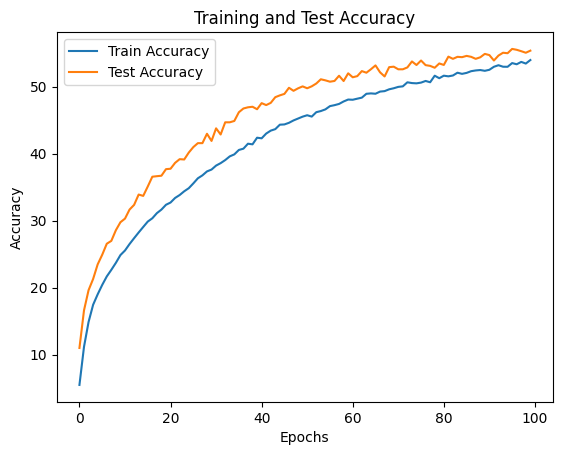

In [88]:
# Plot accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

In [89]:
import random

In [90]:
len(test_dataset)

10000

In [91]:
test_dataset[0][0].unsqueeze(dim=0).shape

torch.Size([1, 3, 32, 32])

In [92]:
test_dataset[0][0] / 2 + 0.5

tensor([[[1.0108, 0.9888, 0.9815,  ..., 1.1354, 1.1428, 1.1941],
         [0.9962, 0.9815, 0.9815,  ..., 1.2454, 1.2600, 1.3187],
         [1.1794, 1.1134, 1.0841,  ..., 1.3333, 1.3407, 1.3847],
         ...,
         [0.0799, 0.0726, 0.0946,  ..., 1.1648, 0.8935, 0.6883],
         [0.0799, 0.1092, 0.1679,  ..., 1.1794, 0.9229, 0.6150],
         [0.1386, 0.1679, 0.1752,  ..., 1.1428, 1.0695, 0.8422]],

        [[1.1948, 1.1642, 1.1566,  ..., 1.3171, 1.3171, 1.3401],
         [1.1566, 1.1413, 1.1566,  ..., 1.4089, 1.4089, 1.4241],
         [1.2789, 1.2330, 1.2254,  ..., 1.4624, 1.4547, 1.4624],
         ...,
         [0.1093, 0.1170, 0.1475,  ..., 1.1413, 0.8355, 0.6291],
         [0.1246, 0.1705, 0.2316,  ..., 1.1719, 0.8814, 0.5603],
         [0.2010, 0.2393, 0.2546,  ..., 1.1337, 1.0343, 0.8049]],

        [[1.4701, 1.4346, 1.4275,  ..., 1.4772, 1.4772, 1.4914],
         [1.3990, 1.3919, 1.4062,  ..., 1.4772, 1.4772, 1.4985],
         [1.4488, 1.4204, 1.4275,  ..., 1.4843, 1.4843, 1.

In [93]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()